# JD Drug Recommendation System 

Current medicine prescribing process is done by medical practitioners who prescribe medicines based on their experiences. However, every person has a unique experience, and the majority of those experiences can only apply to a specific condition, thus mistakes might occur while prescribing in a different situation. Hereby, collaborative filtering recommender system based on the past prescribing records is applied in this prototype to show the possibility of AI recommendation in medicine prescribing. 

In [2]:
# Pandas is a data analysis tool that allows importing data from other file formats
# Numpy facilitate advanced mathematical operation on large numbers of data
# Pyplot is a module in matplotlib that manipulate elements of a figure, create figure
# Seaborn is used for making statistical graphics.
# plot_decision_regions is a function for plotting decision regions of classifiers in 1 or 2 dimensions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# ggplot is used to map data to visual objects that make up the visualization
# we specified the figure format to be svg format
# we use matplotlib to renders the figure inline in this jupyter notebook
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.datasets import fetch_20newsgroups
import gensim
# !python -m pip install -U gensim to install automatically
# pip install python-Levenshtein  to install levenshtein

### 1.0 Import Cleaned data

In this section, the system will read from the cleaned dataset.

In [3]:
# we start reading dataset from a csv file
df_train = pd.read_csv(r'df_train.csv')
df_test = pd.read_csv(r'df_test.csv')
# To drops all missing rows with missing values
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [4]:
# To show current data looks like what
df_train

,drugName,condition,rating,usefulCount,review
0,Guanfacine,ADHD,8.0,192,son halfway fourth intuniv became concerned be...
1,Lybrel,Birth Control,5.0,17,used take another contraceptive pill cycle hap...
2,Ortho Evra,Birth Control,8.0,10,first time using form birth control glad went ...
3,Cialis,Benign Prostatic Hyperplasia,2.0,43,nd started work rock hard erection however exp...
4,Levonorgestrel,Emergency Contraception,1.0,5,pulled cummed bit took plan b hour later took ...
...,...,...,...,...,...
148382,Junel 1.5 / 30,Birth Control,6.0,0,would second junel birth control year changed ...
148383,Metoclopramide,Nausea/Vomiting,1.0,34,given surgey immediately became anxious could ...
148384,Orencia,Rheumatoid Arthritis,2.0,35,limited improvement month developed bad rash m...
148385,Thyroid desiccated,Underactive Thyroid,10.0,79,thyroid medication year spent first synthroid ...


In [5]:
# To show the composition of rating value count from most frequent to least
print("Rating Value_count")
print("------------------")
df_train.rating.value_counts(normalize=True)

Rating Value_count
------------------


10.0    0.310609
9.0     0.170993
1.0     0.134743
8.0     0.117450
7.0     0.058981
5.0     0.050402
2.0     0.043906
3.0     0.041318
6.0     0.039802
4.0     0.031795
Name: rating, dtype: float64

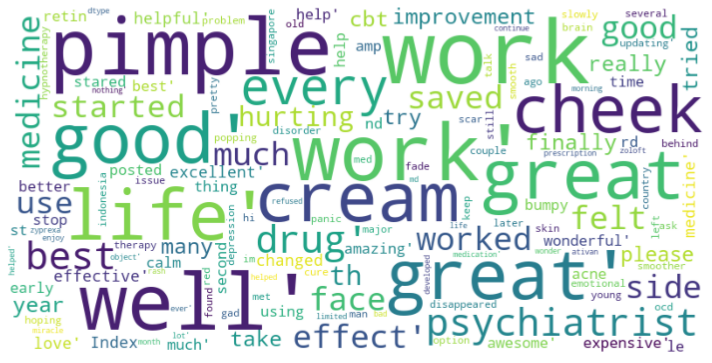

In [6]:
# To display topics that are frequently occur
from wordcloud import WordCloud

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10,8), 
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
        
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
top_words=df_train.review.value_counts(normalize=True)[:40].keys()
plot_wordcloud(top_words)
plt.savefig(r'fig/wordcloud.svg')

### 2.0 Understanding the data

In [7]:
# The list below shows the number of drugs having the same condition
drug_per_condition = df_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drug_per_condition[:30]

condition
Pain                         200
Birth Control                172
High Blood Pressure          140
Acne                         117
Depression                   105
Rheumatoid Arthritis          98
Diabetes, Type 2              89
Allergic Rhinitis             88
Osteoarthritis                80
Bipolar Disorde               80
Insomnia                      78
Anxiety                       78
Abnormal Uterine Bleeding     74
Migraine                      59
Psoriasis                     58
Endometriosis                 57
ADHD                          55
Asthma, Maintenance           54
Chronic Pain                  53
Migraine Prevention           50
Irritable Bowel Syndrome      49
Major Depressive Disorde      49
Urinary Tract Infection       47
ibromyalgia                   45
Postmenopausal Symptoms       44
Bronchitis                    44
HIV Infection                 43
GERD                          43
Bacterial Infection           43
Headache                      42


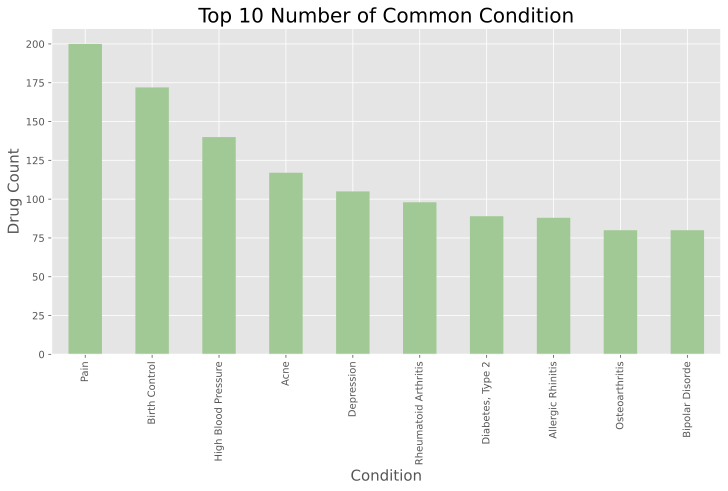

In [8]:
# To list out top 10 number of common conditions, Pyplot library is applied
drug_per_condition[:10].plot(kind="bar", figsize = (12,6), fontsize = 10, color="#a1c995")
plt.xlabel("Condition", fontsize = 15)
plt.ylabel("Drug Count", fontsize = 15)
plt.title("Top 10 Number of Common Condition", fontsize = 20)
plt.savefig(r"fig/top10_condition.svg")

In [9]:
# The list below shows the number of condition contribute to the same condition
condition_per_drug = df_train.groupby(['drugName'])['condition'].nunique().sort_values(ascending=False)
condition_per_drug[:30]

drugName
Gabapentin                   18
Prednisone                   18
Neurontin                    16
Venlafaxine                  15
Duloxetine                   14
Amitriptyline                14
Cymbalta                     14
Effexor XR                   13
Topiramate                   12
Paroxetine                   12
Tramadol                     11
Topamax                      11
Paxil                        11
Sertraline                   11
Cefuroxime                   11
Bupropion                    11
Pristiq                      11
Ciprofloxacin                11
Augmentin                    11
Amoxicillin                  11
Amoxicillin / clavulanate    11
Lyrica                       10
Citalopram                   10
Clarithromycin               10
Clonidine                    10
Levofloxacin                 10
Triamcinolone                10
Naproxen                     10
Desvenlafaxine               10
Cipro                        10
Name: condition, dtype: int64

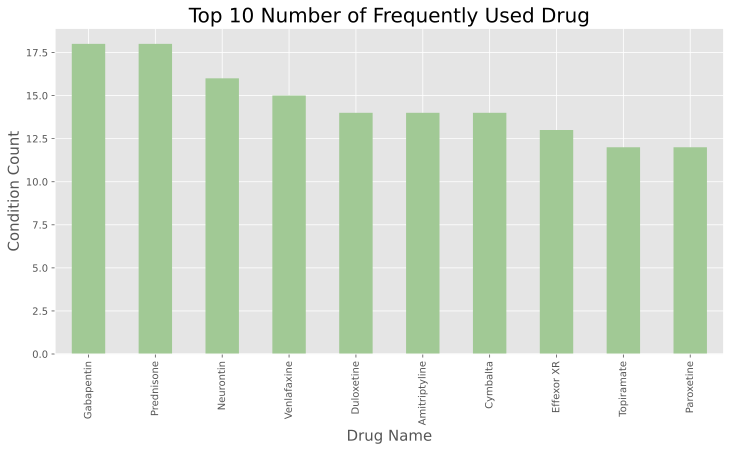

In [10]:
# To list out top 10 of Frequently Used Drug
condition_per_drug[:10].plot(kind="bar", figsize = (12,6), fontsize = 10, color="#a1c995")
plt.xlabel("Drug Name", fontsize = 15)
plt.ylabel("Condition Count", fontsize = 15)
plt.title("Top 10 Number of Frequently Used Drug", fontsize = 20)
plt.savefig(r"fig/top10_drug.svg")

In [11]:
# The list below shows the ratings of drugs and number of review contribute to that rating
rating_per_drug = df_train.groupby(['drugName'])['rating'].value_counts().sort_values(ascending=False)
rating_per_drug[:30]

drugName                            rating
Levonorgestrel                      10.0      1395
Phentermine                         10.0       813
Etonogestrel                        10.0       646
Levonorgestrel                      9.0        611
Ethinyl estradiol / norethindrone   1.0        582
Miconazole                          1.0        569
Etonogestrel                        1.0        530
Varenicline                         10.0       479
Ethinyl estradiol / norethindrone   10.0       470
Escitalopram                        10.0       453
Alprazolam                          10.0       425
Clonazepam                          10.0       419
Plan B                              10.0       413
Etonogestrel                        9.0        404
Chantix                             10.0       397
Nexplanon                           10.0       396
Levonorgestrel                      1.0        383
Ethinyl estradiol / norethindrone   9.0        380
Nexplanon                           1.0

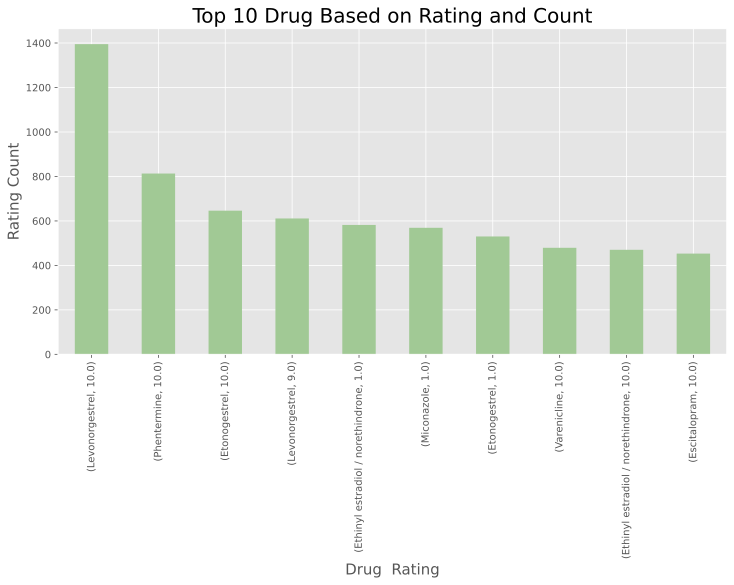

In [12]:
# To list out Top 10 Drug Based on Rating and Count
rating_per_drug[:10].plot(kind="bar", figsize = (12,6), fontsize = 10, color="#a1c995")
plt.xlabel("Drug  Rating", fontsize = 15)
plt.ylabel("Rating Count", fontsize = 15)
plt.title("Top 10 Drug Based on Rating and Count", fontsize = 20)
plt.savefig(r"fig/top10_rating_drug.svg")

### 2.0 Process Data 

In this section, the system will process datas to remove unrelevant dataset.

<AxesSubplot:title={'center':'Review Decomposition Based on Rating'}, xlabel='Rating', ylabel='Number of Review'>

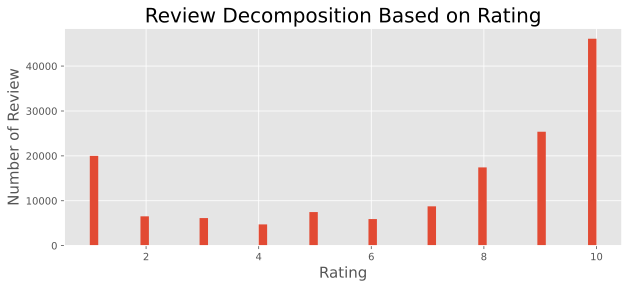

In [13]:
# To plot graph based on their rating and their number of reviews 
plt.figure(figsize =(10, 4)) 
plt.xlabel("Rating", fontsize = 15)
plt.ylabel("Number of Review", fontsize = 15)
plt.title("Review Decomposition Based on Rating", fontsize = 20)
df_train['rating'].hist(bins = 60)

From the figure above, it can be clearly sees that most of the drugs rating are distributed away from middle which indicates most of the datasets are having a high rating. Hence, datasets within rating 4 to 6 is drop/exclude from consideration. Besides, we can observe that the mode of the drugs rating is 10.

In [14]:
# Remove 4-7 star reviews
df_train2 = df_train.drop(df_train[(df_train['rating'] > 4.0) & (df_train['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_train2['sentiment'] = np.where(df_train2['rating'] >= 7, '1', '0')

# At this moment, we know that having sentiment value of 1 meant the drug is having a high rate while 0 sentiment value meant low rate
df_train2

,drugName,condition,rating,usefulCount,review,sentiment
0,Guanfacine,ADHD,8.0,192,son halfway fourth intuniv became concerned be...,1
2,Ortho Evra,Birth Control,8.0,10,first time using form birth control glad went ...,1
3,Cialis,Benign Prostatic Hyperplasia,2.0,43,nd started work rock hard erection however exp...,0
4,Levonorgestrel,Emergency Contraception,1.0,5,pulled cummed bit took plan b hour later took ...,0
5,Aripiprazole,Bipolar Disorde,10.0,32,abilify changed life hope zoloft clonidine fir...,1
...,...,...,...,...,...,...
148382,Junel 1.5 / 30,Birth Control,6.0,0,would second junel birth control year changed ...,0
148383,Metoclopramide,Nausea/Vomiting,1.0,34,given surgey immediately became anxious could ...,0
148384,Orencia,Rheumatoid Arthritis,2.0,35,limited improvement month developed bad rash m...,0
148385,Thyroid desiccated,Underactive Thyroid,10.0,79,thyroid medication year spent first synthroid ...,1


In [15]:
# Remove 4-7 star reviews
df_test2 = df_test.drop(df_test[(df_test['rating'] > 4.0) & (df_test['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_test2['sentiment'] = np.where(df_test2['rating'] >= 7, '1', '0')
# Note that the dataset has mostly positive reviews
df_train2.sentiment.value_counts(normalize=True)

1    0.692961
0    0.307039
Name: sentiment, dtype: float64

In [16]:
# Export the sentiment reading in csv format
export_csv = df_train2.to_csv(r'df_train_sentiment.csv', index = None, header=True)
export_csv = df_test2.to_csv(r'df_test_sentiment.csv', index = None, header=True)

To produce a more  accurate dataset, we also remove stopwords which are not needed.

In [17]:
# Assign their review and their respective sentiment into x and y axis
X_train=df_train2.review
y_train=df_train2.sentiment
X_test=df_test2.review
y_test=df_test2.sentiment
from nltk.corpus import stopwords

# Removing stopwpords
stop = set(stopwords.words('english'))
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't",
     "mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound',]
for j in a:
    stop.add(j)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=0.01, max_df=0.7)
# cv1 = CountVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=10, max_df=0.7)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,able,absolutely,ache,acne,active,actually,add,adhd,affect,age,...,would,xanax,year,yeast,yes,yesterday,yet,yr,zero,zoloft
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


In [19]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.01, max_df=0.7)
# cv2 = CountVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=10, max_df=0.7)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,able,absolutely,ache,acne,active,actually,add,adhd,affect,age,...,year ago,year old,yeast,yeast infection,yes,yesterday,yet,yr,zero,zoloft
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


### 2.1 Logistic Regression

To understand whether the dataset is a useful datasets and powerful, logistic regession is applied to identify the new recommendation fom this datasets is valid or not

In [20]:
lr = LogisticRegression()
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

C:\Users\ND\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


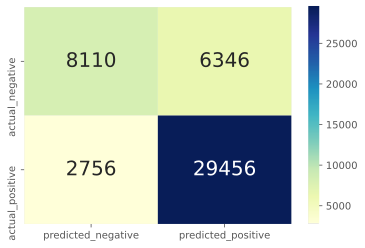

In [21]:
cm1=conf_matrix(y_test, y_pred_cv1)
plt.savefig(r'fig/cm1_lr1.svg')

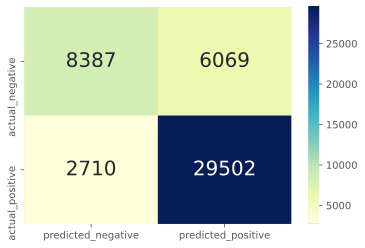

In [22]:
cm2=conf_matrix(y_test, y_pred_cv2)
plt.savefig(r'fig/cm2_lr2.svg')

In [23]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.805,0.812
Precision,0.823,0.829
Recall,0.914,0.916
F1 Score,0.866,0.870


# Various Approach to Recommend Drugs

## A. Collobolative Recommendation Approach - Method I(To compare for similar condition)

Building User-Item Interactions Matrix and compare for similar drug

User-item matrix is a basic foundation of traditional collaborative filtering techniques. In this practical, the rating for target movie item i for an active user can be predicted by using a simple weighted average (mean). 

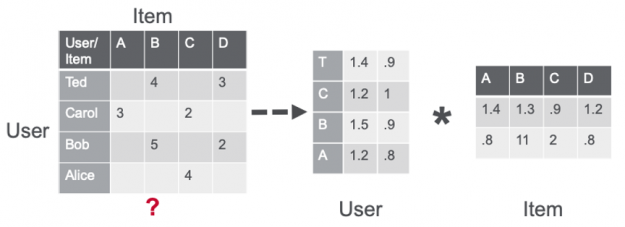

In [24]:
# Sorting values according to the rating 
drugmat = df_train2.pivot_table(index ='drugName',columns ='condition', values ='rating') 

drugmat.head()


condition,ADHD,Abnormal Uterine Bleeding,Acne,Alcohol Withdrawal,Allergic Reactions,Allergic Rhinitis,Anesthesia,Angina,Ankylosing Spondylitis,Anxiety,...,Underactive Thyroid,Upper Respiratory Tract Infection,Urinary Incontinence,Urinary Tract Infection,Urticaria,Vaginal Yeast Infection,Vitamin/Mineral Supplementation during Pregnancy/Lactation,Vulvodynia,Weight Loss,ibromyalgia
drugName,,,,,,,,,,,,,,,,,,,,,
A + D Cracked Skin Relief,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A / B Otic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abacavir / dolutegravir / lamivudine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abacavir / lamivudine / zidovudine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abatacept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# to test the drug matrix
condition = input("Enter a condition(suggest to enter 'Anxiety' for obvious results): ")

# output
drug_user_ratings = drugmat.sort_values(condition, ascending = False).head() 
drug_user_ratings

In [ ]:
# This indicates the medicine which is suitable for the input condition
drug_user_ratings[condition][:10]

In [ ]:
# analysing correlation with similar condition 
similar_to_condition = drug_user_ratings.corrwith(drugmat) 
  
corr_Condition = pd.DataFrame(similar_to_condition, columns =['Correlation']) 
corr_Condition.dropna(inplace = True) 
  
corr_Condition.head(20) 

By comparing the correlation, we can draw a prediction that these condition with high correlation is similar to the input condition and have a high chance that it can be cure by similar drug. A typical example is the anxiety disorder and panic disorder.

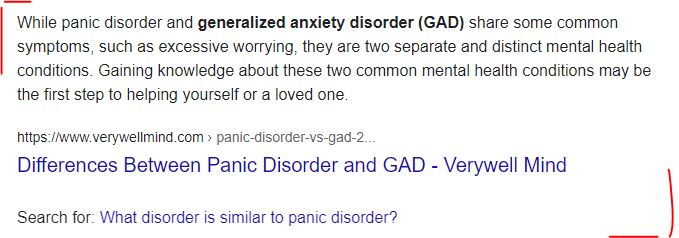

## B. Collobolative Recommendation Approach - Method II(To compare for similar drug)

In [ ]:
# Sorting values according to the rating 
drugmat2 = df_train2.pivot_table(index ='condition',columns ='drugName', values ='rating') 

drugmat2.head()

In [ ]:
# to test the drug matrix
drug = input("Enter a drug(suggested 'Abilify' for obvious results): ")

# output
drug_user_ratings2 = drugmat2.sort_values(drug, ascending = False).head() 
drug_user_ratings2

In [ ]:
# This indicates the medicine which is suitable for the input condition
drug_user_ratings2[drug][:10]

In [ ]:
# analysing correlation with similar condition 
similar_drug = drug_user_ratings2.corrwith(drugmat2) 
  
corr_Drug = pd.DataFrame(similar_drug, columns =['Correlation']) 
corr_Drug.dropna(inplace = True) 
  
corr_Drug.head(20) 

By comparing the correlation, we can draw a prediction that these drug with high correlation is similar to the input drug and have a high chance to apply for recover similar condition. A typical example is Abilify, Lurasidone, Olanzapine and Geodon


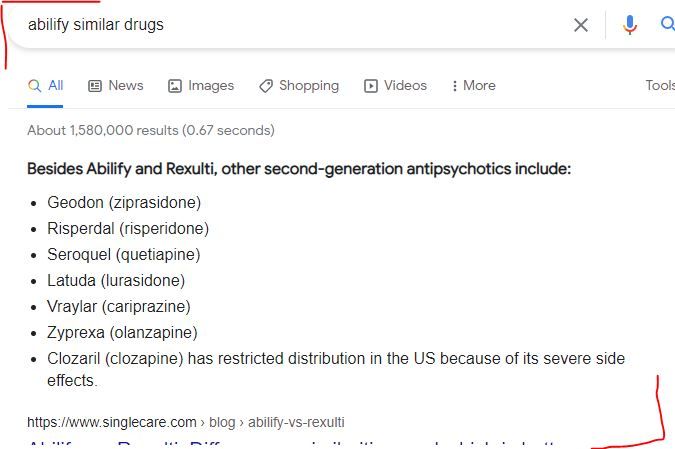

# C. Simplest Recommendation Approach - Method I (based on rating)

In [ ]:
#User Define condition(Recommendation based on condition)
# UI
print("Welcome to this JD Drug Recommendation System~")
condition = input("Enter a condition: ")
print("")

# program logic (if condition is true)
for char in condition:
    if char == condition[0]:
        condition_1 = char.upper()
    else:
        condition_1 += char
                    
# declaration                    
df_condition_1 = df_train.loc[(df_train["condition"] == condition_1)]

# output
drug_based_on_condition = df_condition_1.groupby(['drugName']+['condition'])['rating'].value_counts().sort_values(ascending=False)
drug_based_on_condition[:10]

In [ ]:
# to list out top 5 result frrom previous section
drug_based_on_condition[:5].plot(kind="bar", figsize = (10,6), fontsize = 10, color="#a1c995")
plt.xlabel("Drug Name", fontsize = 15)
plt.ylabel("Rating Count", fontsize = 15)
plt.title("Top 5 Drug Suggested For " + condition_1, fontsize = 20)

# D. Simplest Recommendation Approach - Method II (based on IMDB score)

In [ ]:
#User Define condition(Recommendation based on condition) - Version 2

m = df_train['rating'].quantile(0.90) 
C = df_train['rating'].mean()

# UI
print("Welcome to this JD Drug Recommendation System~")
condition = input("Enter a condition(first char uppercase): ")
print("")


# Function 
def weighted_rating(df_train, m=m, C=C):
    v = df_train['rating']
    R = df_train['rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

# program logic (if condition is true)
for char in condition:
    if char == condition[0]:
        condition_1 = char.upper()
    else:
        condition_1 += char
                    
# declaration         
pre_condition = df_train                    
pre_condition['score'] = pre_condition.apply(weighted_rating, axis=1)
pre_condition['score'].head()
df_condition_1 = pre_condition.loc[(df_train["condition"] == condition_1)]

# output
drug_based_on_condition = df_condition_1.groupby(['drugName']+['condition'])['score'].value_counts().sort_values(ascending=False)
drug_based_on_condition[:10]

In [ ]:
#Sort drugs based on score calculated above
df_condition_2 = df_condition_1.sort_values('score', ascending=False)

#Print the top 15 drugs recommended
df_condition_2[['drugName', 'condition', 'rating', 'score']].head(20)